In [1]:
# STEP 1 #

# Import neccesary modules
# Set matplotlib to inline mode for the Jupyter notebook visualisations

%matplotlib inline

import rospy
from sensor_msgs.msg import LaserScan
from nav_msgs.srv import GetMap
from nav_msgs.msg import OccupancyGrid

import numpy as np
import matplotlib.pyplot as plt

import numpy as np

import copy
import time
import math

# define the map resolution and scan variable
resolution = None
scan = None

# Helper method for retrieving the map
def getMap() -> OccupancyGrid:
    """ Loads map from map service """
    # Create service proxy
    get_map = rospy.ServiceProxy('static_map', GetMap)
    # Call service
    recMap = get_map()
    recMap = recMap.map
    # the map resolution
    global resolution
    resolution = float(recMap.info.resolution)
    # Return
    return recMap

def splitMap(map):
    """ Iterates over the map cells and add each to a corresponding list
        according to whether it is a wall or free space
        Arguments:
        map: OccupancyGrid, 
             header with metadata and a value for each pixel - 
             each a percentage chance of empty or occupied space.
    """
    # the arrays to hold the free and wall cells in the map
    global wallPositions
    wallPositions = None
    global freePositions
    freePositions = None

    # info from the OccupancyGrid
    mapData = np.array(map.data)
    mapInfo = map.info
    # convert the data to a 2d array (coordinates with occupancy certainty)
    map = np.split(mapData, map.info.width)
    
    # iteration counters serving as indices for the arrays
    x:int = 0 
    y:int = 0

    # nested loop to go through each cell
    # certainty of occupance is rated 0 - 100
    for row in map:
        for cell_occupancy in row:
            # convert the local map coordinated to global goordinates
            x_coord = x*mapInfo.resolution + mapInfo.origin.position.x + mapInfo.resolution/2
            y_coord = y*mapInfo.resolution + mapInfo.origin.position.y + mapInfo.resolution/2
            pos = np.array([[x_coord, y_coord]])
            if cell_occupancy == 0:
                # add to empty space list
                # if its the first element, initialize. Else, add the coords to the existing arr
                if freePositions is not None:
                    freePositions = np.vstack((freePositions, pos))
                else:
                    freePositions = pos
            else:
                # add to wall list
                if wallPositions is not None:
                    wallPositions = np.vstack((wallPositions, pos))
                else:
                    wallPositions = pos
            #increment the iteration counter for the cells in the row
            y += 1
        # reset the cell counter to the start and increment the row counter
        y = 0
        x += 1

def laserScanSubCallback(msg):
    """ Loads the laserscan from message """
    # check if the map has been received and read, else return until it has
    if resolution is None:
        return
        
    # arrange the angles evenly spaced between min and max values at
    angles = np.arange(msg.angle_min, msg.angle_max, msg.angle_increment)

    global scan
    # iterate over every range and angle pair and calculate the cartesian coordinates for each
    # ranges are adjusted to account for wall thickness
    for distance, angle in zip(msg.ranges, angles):
        x = math.sin(angle)*distance
        if x < 0:
            x = x - resolution/2
        elif x > 0:
            x = x + resolution/2
        y = math.cos(angle)*distance
        if y < 0:
            y = y - resolution/2
        elif y > 0:
            y = y + resolution/2
        pos = np.array([[x, y]])
        # if its the first element, initialize. Else, add the coords to the existing arr
        if scan is not None:
            scan = np.vstack((scan, pos))
        else:
            scan = pos

# subscriber of the laserscan topic
laserScanSub = rospy.Subscriber("/scan", LaserScan, laserScanSubCallback)

# Initiate ROS node
rospy.init_node('mazeEscape')
recMap = getMap()

# split the map into free and wall cells
splitMap(recMap)

# wait for the laserscan data to be received before plotting it
dump = rospy.wait_for_message("/scan", LaserScan, 9999999)

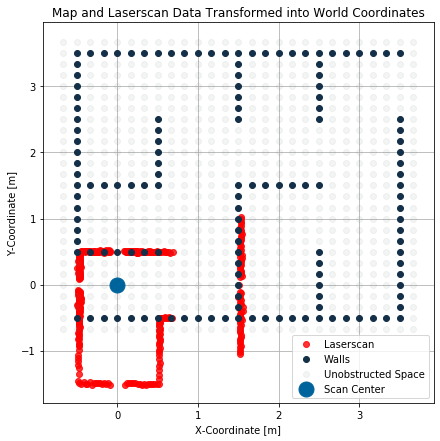

In [2]:
# Store colours matching UAS TW colour scheme as dict 
colourScheme = {
    "darkblue": "#143049",
    "twblue": "#00649C",
    "lightblue": "#8DA3B3",
    "lightgrey": "#CBC0D5",
    "twgrey": "#72777A"
}

## Visualise transformed maze and scans
# Create single figure
plt.rcParams['figure.figsize'] = [7, 7]
fig, ax = plt.subplots()

# Plot data as points (=scatterplot) and label accordingly. The colours are to look nice with UAS TW colours
ax.scatter(scan[:,1], scan[:,0], c="r", alpha=0.8, label="Laserscan")
ax.scatter(wallPositions[:,1], wallPositions[:,0], c=colourScheme["darkblue"], alpha=1.0, s=6**2, label="Walls")
ax.scatter(freePositions[:,1], freePositions[:,0], c=colourScheme["twgrey"], alpha=0.08, s=6**2, label="Unobstructed Space")
ax.scatter([0], [0], c=colourScheme["twblue"], s=15**2, label="Scan Center")

# Set axes labels and figure title
ax.set_xlabel("X-Coordinate [m]")
ax.set_ylabel("Y-Coordinate [m]")
ax.set_title("Map and Laserscan Data Transformed into World Coordinates")

# Set grid to only plot each metre
ax.set_xticks = [-1, 0, 1, 2, 3, 4 ]
ax.set_yticks = [-1, 0, 1, 2, 3, 4 ]

# Move grid behind points
ax.set_axisbelow(True)
ax.grid()

# Add labels
ax.legend()

# Show plot
plt.show()

In [3]:
# STEP 2 #

# Import kNN implementation
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

y_wall = [1] * wallPositions.shape[0]
y_free = [0] * freePositions.shape[0]
y = np.hstack((y_wall, y_free))

X = np.vstack((wallPositions, freePositions))

clf = KNeighborsClassifier(n_neighbors=1, weights = "uniform")

clf.fit(X, y)

KNeighborsClassifier(n_neighbors=1)

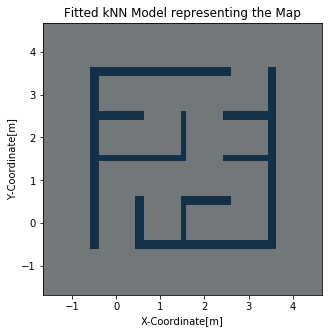

In [4]:
# Imports for visualisation
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay

## Visualise fitted model using built-in visualiser
plt.rcParams['figure.figsize'] = [5, 5]
_, ax = plt.subplots()

DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    cmap=ListedColormap(
        [
            colourScheme["twgrey"],
            colourScheme["darkblue"]
        ]
    ),
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    xlabel="X-Coordinate[m]",
    ylabel="Y-Coordinate[m]",
    shading="auto",
)

# Set title and show plot
ax.set_title("Fitted kNN Model representing the Map")
plt.show()

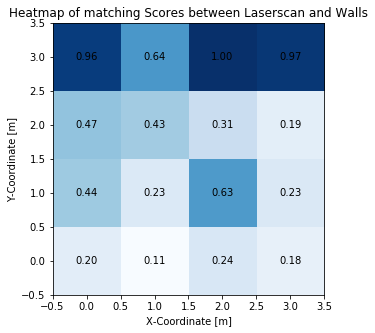

In [5]:
# Import necessary modules
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import re

# Assuming clf is your fitted kNN classifier, and scan is your laserscan data

# Define the maze size (assuming whole numbers for coordinates)
mazeX, mazeY = 4, 4  # Update with actual size

# Define possible robot positions on the grid (whole number coordinates)
positions = [(x, y) for x in range(mazeX) for y in range(mazeY)]

# Function to transform the scan to the given position
def transform_scan(scan, position):
    # Move the scan to the new position
    transformed_scan = scan + np.array(position)
    return transformed_scan

# Predict the classification for each scan at each position
scores = []
for position in positions:
    transformed_scan = transform_scan(scan, position)
    # Predict if each point in the scan is a wall (1) or free space (0)
    predictions = clf.predict(transformed_scan)
    # Count the number of points predicted as walls
    score = np.sum(predictions)
    scores.append(score)

# Normalize scores to range from 0 to 1 for better visualization
max_score = max(scores)
scores = [score / max_score for score in scores]

# Create a Numpy array to hold scores for visualization
scoreArr = np.zeros((mazeX, mazeY), dtype=np.float64)
for idx, val in zip(positions, scores):
    scoreArr[idx] = val

# Visualize the scores as a heatmap
plt.rcParams['figure.figsize'] = [5, 5]
fig, ax = plt.subplots()
cmap = plt.cm.Blues  # Use a blue colormap for the heatmap
im = ax.imshow(scoreArr, cmap=cmap, origin='lower')

# Annotate each cell with the score
for i in range(mazeX):
    for j in range(mazeY):
        text = ax.text(j, i, f"{scoreArr[i, j]:.2f}",
                       ha="center", va="center", color="black")

# Set title and axes labels
ax.set_title("Heatmap of matching Scores between Laserscan and Walls")
ax.set_xlabel("X-Coordinate [m]")
ax.set_ylabel("Y-Coordinate [m]")

# Show the plot
plt.show()
